#### Nombre: Juan Antonio Martos Navarro

En esta práctica, se usará un dataset que se ha obtenido a partir de las puntuaciones que cada estudiante completó al rellenar una hoja de cálculo (donde incluiréis vuestros gustos por las películas que se indican).

Se ha implementado una clase k-NN basada en usuario. Se calcula la predicción para cada usuario e item como:

  > $\hat r (u, x) = c \sum sim(u, v) r(v, x)$ 

  > $c = \frac{1}{\sum |sim(u, v)|}$

Como medida de similitud se han implementado tanto el coseno como la correlación de Pearson:

  > $sim(u, v) = cos(r(u), r(v)) = \frac{\sum r(u, x)r(v, x)}{\sqrt {\sum r(u, x)^2r(v, x)^2}}$

  > $sim(u, v) = \frac{\sum (r(u, x) - \bar{r}(u))(r(v, x) - \bar{r}(v)}{\sqrt{\sum (r(u, x) - \bar{r}(u))^2 \sum (r(v, x) - \bar{r}(v))^2}}$ 

Para cada usuario e item seleccionamos los K usuarios con mayor similitud que además hayan visto el item en los datos de entrenamiento. Si el usuario no tiene vecinos calculamos la predicción del usuario e item como la media de los ratings del item en los datos de entrenamiento. Por último acotamos las predicciones al intervalo $[1, 5]$

In [2]:
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/INE/PRÁCTICA\5')

In [5]:
%cd drive/MyDrive/INE/PRÁCTICA\ 5

/content/drive/MyDrive/INE/PRÁCTICA 5


In [6]:
training_data = pd.read_csv('cf-dataset/training-matrix.dat', sep='\t')
test_data = pd.read_csv('cf-dataset/test-matrix.dat', sep='\t')

In [7]:
training_data.replace(np.nan, 0, inplace=True) # Replace NaN values with 0s.
training_data.drop(['item'], axis=1, inplace=True) # Drop item column.
training_data.head()

,0,1,2,3,4,5,6,7,8,11,12,13,14,15,17,18,19,21
0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0
1,4.0,0.0,2.5,3.0,2.5,0.0,0.0,4.0,3.0,0.0,0.0,2.0,3.0,3.0,3.0,0.0,4.0,4.0
2,4.0,0.0,0.0,3.0,2.0,0.0,3.5,5.0,3.0,0.0,0.0,3.0,3.0,3.0,2.0,0.0,4.0,4.0
3,0.0,4.0,4.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,3.0,4.0,0.0,5.0,0.0,0.0,3.0
4,0.0,3.5,0.0,3.5,2.5,0.0,4.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,2.5,0.0,0.0


In [8]:
test_data.replace(np.nan, 0, inplace=True)
test_data.drop(['item'], axis=1, inplace=True)
test_data.head()

,0,1,2,3,4,5,6,7,8,11,12,13,14,15,17,18,19,21
0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
1,0.0,3.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,3.5,2.5,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0


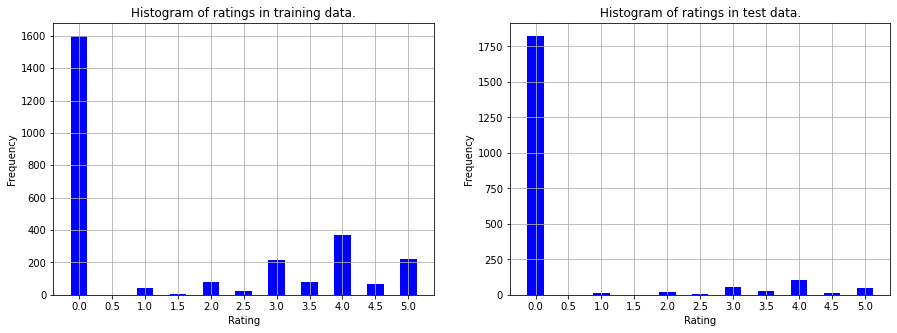

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for data, ax in zip([training_data, test_data], axs.ravel()):
    values, height = np.unique(np.hstack(data.values), return_counts=True)
    ax.bar(values, height, width=0.25, color='blue')
    ax.set_xticks(np.arange(0, 5.5, 0.5))
    ax.set_xlabel('Rating')
    ax.set_ylabel('Frequency')
    ax.grid()

axs[0].set_title('Histogram of ratings in training data.')
axs[1].set_title('Histogram of ratings in test data.')
plt.show()

In [82]:
class UserKNN():
    def __init__(self, k, similarity='cosine'):
        self.k = k
        valid = {'cosine', 'pearson_correlation'}
        if similarity not in valid:
            raise ValueError(f'similarity must take values {valid}')
        self.similarity = similarity
        
    def fit(self, data): 
        self.ratings = data.to_numpy() # Get ratings from training data.
        # Compute similarity between users and store it in similarity_matrix.
        n_items = data.shape[0]
        n_users = data.shape[1]
        self.similarity_matrix = np.zeros((n_users, n_users)) # Initialize similarity matrix.
        for u in range(n_users):
            for v in range(n_users):
                if u != v and self.similarity == 'cosine':
                    # Similarity computed with cosine.
                    self.similarity_matrix[u, v] = self.cosine(u, v)
                elif u != v and self.similarity == 'pearson_correlation':
                    # Similarity computed with pearson correlation.
                    self.similarity_matrix[u, v] = self.pearson_correlation(u, v)
        
        self.kNeighbours = {}
        for u in range(n_users):
            for x in range(n_items):
                self.kNeighbours[(u, x)] = [idx for idx in np.argsort(self.similarity_matrix[:, u]) if self.ratings[x, idx] > 0][-self.k:] # Select K-Neighbours with greater similarity only if they rated the item.

        return self
    
    def cosine(self, u, v):
        ru = self.ratings[:, u]
        rv = self.ratings[:, v]
        num = np.sum(ru * rv)
        den = np.sqrt(np.sum(ru**2) * np.sum(rv**2))
        return num / den
    
    def pearson_correlation(self, u, v):
        ru = self.ratings[:, u] 
        rv = self.ratings[:, v]         
        num = np.sum( (ru - np.mean(ru)) * (rv - np.mean(rv)) )
        den = np.sqrt(np.sum((ru - np.mean(ru))**2) * np.sum(rv - np.mean(rv))**2)
        return num / den if den > 0 else 0

    def predict(self, data):
        n_users = data.shape[1]
        n_items = data.shape[0]
        preds = np.zeros((n_users, n_items)) # Initialize preds matrix.
        for x, u in zip(*data.to_numpy().nonzero()): # Iterate through items and users with non-zero ratings.            
            c = np.sum(abs(self.similarity_matrix[u, self.kNeighbours[(u, x)]]))
            sim_uv = self.similarity_matrix[u, self.kNeighbours[(u, x)]]

            if c > 0: preds[u, x] = (1/c) * np.sum(sim_uv * self.ratings[x, self.kNeighbours[(u, x)]]) 
            else: preds[u, x] = np.mean(self.ratings[x, :][self.ratings[x, :] > 0]) # If user has no neighbours assign mean value of ratings of the item (when they are not 0).
            
            preds[u, x] = np.clip(preds[u, x], a_min=1, a_max=5) # Limit results to interval [1, 5]. 
        
        return pd.DataFrame(preds.T, columns=data.columns) # Transpose to match test_data shape.

In [83]:
model = UserKNN(k=5, similarity='cosine')
model.fit(training_data)
preds_User = model.predict(test_data)

preds_User = preds_User.applymap('{:.1f}'.format) # 1 decimal format.
preds_User.head()

,0,1,2,3,4,5,6,7,8,11,12,13,14,15,17,18,19,21
0,3.6,0.0,4.2,0.0,0.0,0.0,0.0,3.6,0.0,0.0,0.0,0.0,0.0,0.0,3.8,0.0,0.0,0.0
1,0.0,3.3,0.0,0.0,0.0,0.0,3.4,0.0,0.0,0.0,3.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,3.2,3.2,0.0,0.0,0.0,0.0,0.0,0.0,3.2,3.2,0.0,0.0,0.0,0.0,3.6,0.0,0.0
3,3.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,0.0,0.0,0.0,3.4,0.0,0.0,0.0,0.0,0.0,3.1


In [84]:
test_data.head()

,0,1,2,3,4,5,6,7,8,11,12,13,14,15,17,18,19,21
0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
1,0.0,3.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,3.5,2.5,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0


A continuación, calculamos el Mean Absolute Error (MAE) y el Root Mean Squared Error (RMSE) de las predicciones $\hat{r}(u, x)$ de la siguiente forma:

> $MAE = \frac{1}{|R_{test}|} \sum |\hat{r}(u, x) - r_{test}(u, x)|$ 

> $RMSE = \sqrt{\frac{1}{|R_{test}|} \sum ((\hat{r}(u, x) - r_{test}(u, x))^2}$

In [85]:
def calc_errors(y, y_pred):
    # We only take into account items that have been rated.
    r_pred = y_pred[y_pred.nonzero()]
    r_test = y[y.nonzero()]
    R_test = len(r_test) # Number of rated items in test.
    
    mae = 1/R_test * np.sum(abs(r_pred - r_test))
    rmse = np.sqrt(1/R_test * np.sum((r_pred - r_test)**2))

    return mae, rmse

,MAE(cosine),RMSE(cosine),MAE(pearson_correlation),RMSE(pearson_correlation)
k,,,,
1,1.024823,1.332890,1.100182,1.415591
3,0.895686,1.131290,0.998651,1.322808
5,0.885097,1.116544,0.980984,1.301456
7,0.881822,1.110269,1.007823,1.310565
9,0.868794,1.098027,1.000877,1.297752
11,0.864228,1.092495,1.003474,1.303328
13,0.861803,1.091815,1.008957,1.309175
15,0.861088,1.092176,1.010988,1.312545
17,0.861136,1.092225,1.011367,1.312609


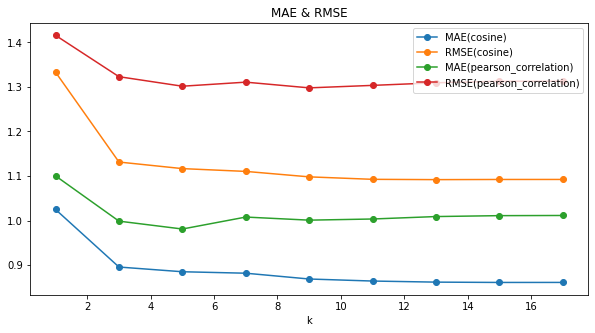

In [87]:
ks = np.arange(1, 19, 2)
errors = []
for similarity in ['cosine', 'pearson_correlation']:
  for k in ks:
      model = UserKNN(k, similarity)
      model.fit(training_data)
      preds = model.predict(test_data)
      mae, rmse = calc_errors(test_data.to_numpy(), preds.to_numpy())
      errors.append({'k': k, f'MAE({similarity})': mae, f'RMSE({similarity})': rmse})

errors = pd.DataFrame(errors).groupby('k').first()
display(errors)
errors.plot(figsize=(10, 5), marker='o')
plt.title('MAE & RMSE')
plt.show()

Se observa que los errores calculando la similitud a partir de la correlación de Pearson son ligeramente superiores. Por otro lado, se observa que el error más alto en todos los casos se da para $k=1$.

Por último, calculamos la precisión (P@N) y el recall (P@N) de las predicciones para distintos *cutoffs* considerando como items relevantes aquellos que tienen un rating mayor que 3 en test.

> $P@N = \frac{1}{|U|} \sum \frac{|Rel_u@N|}{N}$

> $R@N = \frac{1}{|U|} \sum \frac{|Rel_u@N|}{|Rel_u|}$

> Donde:
  * $Rel_u$ es el número de items relevantes.
  * $Rel_u@N$ es el número de items relevantes en el top N.

In [96]:
def metrics_calculation(y, y_pred, cutoff):
    n_users = y.shape[1]
    precision, recall = np.zeros(n_users), np.zeros(n_users)
    for u in range(n_users):
        ru = y[:, u] # Real ratings for user u.
        ru_pred = y_pred[:, u] # Predicted ratings for user u.
        
        rel_u = np.where(ru > 3) # Indexes of True Relevant items.
        top_k = np.argsort(ru_pred)[-cutoff:] # Indexes of Top K predicted items.
        
        rel_uk = (np.isin(top_k, rel_u)).sum() # Number of Top K predicted items that are relevant.
        
        precision[u] = rel_uk / cutoff
        recall[u] = rel_uk / len(rel_u[0])
      
    return np.mean(precision), np.mean(recall) # Mean by user.

,Precision,Recall
Cutoff,,
10,0.650000,0.682207
20,0.494444,0.976586
30,0.350000,1.000000
40,0.262500,1.000000
50,0.210000,1.000000
60,0.175000,1.000000
70,0.150000,1.000000
80,0.131250,1.000000
90,0.116667,1.000000


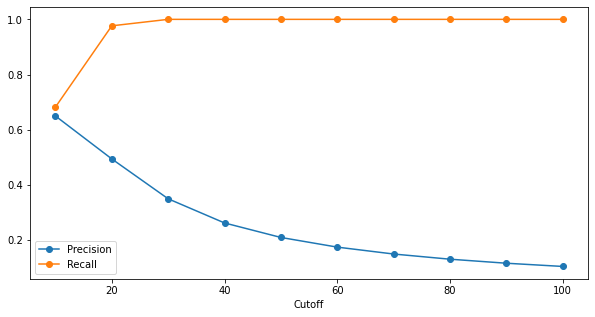

In [97]:
cutoffs = np.arange(10, 110, 10)
metrics = []
for cutoff in cutoffs:
    precision, recall = metrics_calculation(test_data.to_numpy(), preds.to_numpy(), cutoff)
    metrics.append({'Cutoff': cutoff, 'Precision': precision, 'Recall': recall})

metrics = pd.DataFrame(metrics).set_index('Cutoff')
display(metrics)
metrics.plot(figsize=(10, 5), marker='o')
plt.show()

Se observa que la precisión decrece a medida que aumentamos el *cutoff* mientras que el recall aumenta hasta llegar a 1. Esto se debe a que (considerando como items relevantes aquellos que tienen un rating mayor que 3) los usuarios cuentan únicamente con una media de 10.5 items relevantes.

### Opcional: Matrix Factorization.

Para implementar el algoritmo de *Matrix Factorization* calculamos las predicciones para cada usuario e item como $\hat{r_{ui}} = q_{i}^t\ p_{u}$, donde:

* $q_{i}$ es un vector en $\mathbb{R}^f$ asociado a cada item.
* $p_u$ es un vector  en $\mathbb{R}^f$ asociado a cada usuario.

Dichos vectores se inicializan de forma aleatoria y se actualizan en cada iteración mediante descenso por gradiente estocástico hasta que se alcanza el criterio de parada ($RMSE < \epsilon$):

> $q_{i} = q_{i} + \gamma (e_{ui} * p_{u} - \lambda * q_{i})$

> $p_{u} = p_{u} + \gamma (e_{ui} * q_{i} - \lambda * p_{u})$

Donde $e_{ui}$ es el error de cada predicción $e_{ui} = r_{ui} - \hat{r_{ui}}$

In [55]:
np.random.seed(123) # Seed for replicability.
from tqdm import tqdm

class Matrix_Factorization():
  def __init__(self, n_factors=20, gamma=0.05, lamb=0.0001, eps=1e-3, max_iter=500):
    self.n_factors = n_factors
    self.gamma = gamma
    self.lamb = lamb
    self.eps = eps
    self.max_iter = max_iter    

  def fit(self, data):
    n_users = data.shape[1]
    n_items = data.shape[0]

    self.ratings = data.to_numpy() # Get True Ratings from Training Data.
    
    # Initialize all qi and pu vectors with random values.
    self.qi = np.random.rand(n_items, self.n_factors) # Vector for each item in R^(n_factors) space.
    self.pu = np.random.rand(n_users, self.n_factors) # Vector for each user in R^(n_factors) space.
    
    preds = np.zeros((n_users, n_items))
    for i in tqdm(range(self.max_iter), desc='Iterations...'):
      for x, u in zip(*self.ratings.nonzero()):
        preds[u, x] = self.qi[x, :] @ self.pu[u, :]
        error = self.ratings[x, u] - preds[u, x]

        # Upload vectors (SGD).
        self.qi[x, :] += self.gamma * (error * self.pu[u, :] - self.lamb * self.qi[x, :])
        self.pu[u, :] += self.gamma * (error * self.qi[x, :] - self.lamb * self.pu[u, :])
        
      # Get RMSE for stop criteria.
      _, rmse = calc_errors(preds.T, self.ratings)
      if rmse < self.eps: 
        print(f'\nTraining finished after {i+1} epochs.')
        break

    print(f'Final RMSE in training: {rmse}')

    return self

  def predict(self, data):
    n_users = data.shape[1]
    n_items = data.shape[0]

    preds = np.zeros((n_users, n_items))
    for x, u in zip(*data.to_numpy().nonzero()):
      preds[u, x] = self.qi[x, :].T @ self.pu[u, :]
      preds[u, x] = np.clip(preds[u, x], 1, 5)

    return pd.DataFrame(preds.T, columns=data.columns)

In [56]:
model = Matrix_Factorization()
model.fit(training_data)
preds_mf = model.predict(test_data)

preds_mf = preds_mf.applymap('{:.1f}'.format)
preds_mf.head()

Iterations...:  47%|████▋     | 235/500 [00:08<00:09, 27.72it/s]


Training finished after 236 epochs.
Final RMSE in training: 0.0009990626277183764


,0,1,2,3,4,5,6,7,8,11,12,13,14,15,17,18,19,21
0,2.7,0.0,2.1,0.0,0.0,0.0,0.0,3.6,0.0,0.0,0.0,0.0,0.0,0.0,4.7,0.0,0.0,0.0
1,0.0,3.2,0.0,0.0,0.0,0.0,3.3,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,3.4,2.8,0.0,0.0,0.0,0.0,0.0,0.0,3.9,4.7,0.0,0.0,0.0,0.0,4.0,0.0,0.0
3,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.4,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.7


In [57]:
test_data.head()

,0,1,2,3,4,5,6,7,8,11,12,13,14,15,17,18,19,21
0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
1,0.0,3.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,3.5,2.5,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0


In [58]:
mae, rmse = calc_errors(test_data.to_numpy(), preds_mf.to_numpy(dtype=float))
print(f'MAE: {mae}\nRMSE: {rmse}')

MAE: 0.8698581560283688
RMSE: 1.1607804906689854


Se observa que los errores obtenidos son ligeramente inferiores a los obtenidos mediante un kNN basado en usuario.

### Opcional: Movielens Dataset

In [62]:
# user id | item id | rating | timestamp.
movielens = pd.read_csv('ml-100k/u.data', sep='\t', header=None, usecols=[0, 1, 2], names=['user id', 'item id', 'rating'])
movielens.head()

,user id,item id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [63]:
# Get Matrix (n_items x n_users) from DataFrame.
n_rows = len(np.unique(movielens['item id']))
n_cols = len(np.unique(movielens['user id']))

## Fill items not rated by users with NaN values.
full_movielens = movielens.pivot_table(index=['user id'], values='rating', columns='item id').\
                 reindex(columns=range(1, n_rows+1)).stack(dropna=False).to_frame('rating').reset_index()

full_movielens.replace(np.nan, 0, inplace=True) ## Replace NaN values with 0s.

movielens_matrix = pd.DataFrame(full_movielens['rating'].values.reshape(n_rows, n_cols))
print(f'Number of items: {n_rows}\nNumber of users: {n_cols}')
movielens_matrix.head()

Number of items: 1682
Number of users: 943


,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Split dataset in training (80%) and test(20%)
from sklearn.model_selection import train_test_split

training_movielens, test_movielens = train_test_split(movielens_matrix, test_size=0.2)
training_movielens.reset_index(drop=True, inplace=True)
test_movielens.reset_index(drop=True, inplace=True)

In [65]:
model = UserKNN(20, 'cosine')
model.fit(training_movielens)
preds_movielens = model.predict(test_movielens)

preds_movielens = preds_movielens.applymap('{:.1f}'.format)
preds_movielens.head()

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,3.6,3.7,3.7,3.4,3.5,3.4,3.5,3.6,3.6,0.0,...,0.0,0.0,0.0,0.0,0.0,2.8,0.0,0.0,3.3,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
test_movielens.head()

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,4.0,2.0,3.0,4.0,4.0,3.0,3.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
mae, rmse = calc_errors(test_movielens.to_numpy(), preds_movielens.to_numpy(dtype=float))
print(f'MAE: {mae}\nRMSE: {rmse}')

MAE: 0.9653129411764705
RMSE: 1.2036816073051484


En primer lugar, se observa que debido al significativo aumento del tamaño de la matriz de ratings el modelo tiene un tiempo de ejecución muy superior. En cuanto a los errores obtenidos son ligeramente superiores a los obtenidos sobre el dataset inicial. Sin embargo, una desviación en la predicción de en torno a 1 aún puede ser aceptable.